# Anharmonic frequency shifts of normal modes in five-wire trap

The following notebook presents calculatino of anharmonic modes of 5 ion crystal in a five-wire planar trap.

Contents:

1) five-wire trap initialization  
2) Simulation of 5 ions, single species  
3) Normal modes calculation  
4) Anharmonic modes calculation


In [33]:
from __future__ import division
import pylion as pl
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from mpl_toolkits.mplot3d import Axes3D
from electrode import (System, PolygonPixelElectrode, PointPixelElectrode, shaped)

import sion as sn

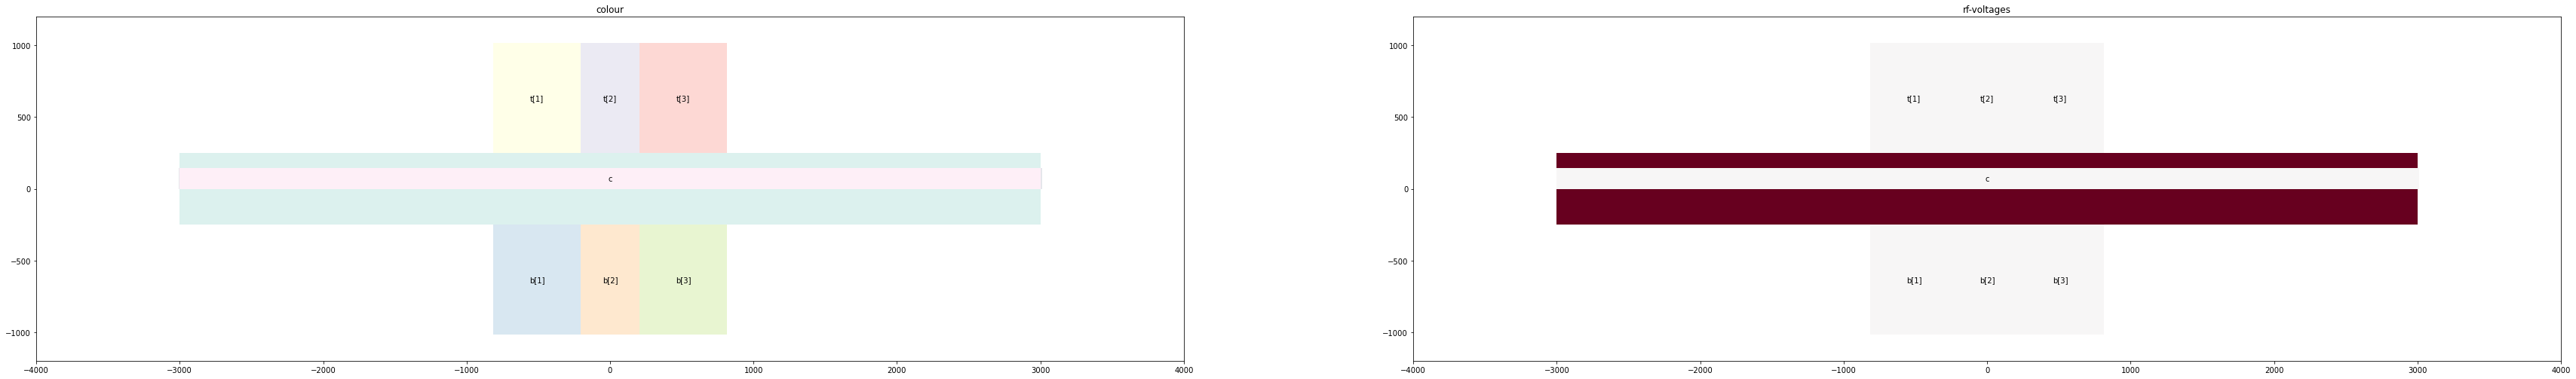

In [34]:
# define trap with large anharmonicity 
L = 1e-6 # length scale
Vrf = 200. # RF peak voltage in V
mass = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*20e6 # RF frequency in rad/s
Urf = Vrf * np.sqrt(Z / mass) / (2 * L * Omega)
scale = Z / ((L * Omega) ** 2 * mass)


# parameters of trap
DCtop = [[760, 600],[1000-240, 400],[760, 600] ]  # Array of lengths and widths of Top electrodes
DCbottom = [[760, 600],[1000-240, 400],[760, 600] ]  # Array of lengths and widths of Bottom electrodes
cwidth = 140  # Width of central dc electrode
clength = 6000 # length of central dc electrode
boardwidth = 10  # width of gaps between electrodes
rftop = 100  # width of top rf electrode, not including width of central electrode
rflength = 6000  # length of rf electrodes
rfbottom = 240  # width of bottom rf electrode

s, RF_electrodes, DC_electrodes = sn.five_wire_trap_design(Urf, DCtop, DCbottom, cwidth, clength, boardwidth, rftop, rflength, rfbottom, need_coordinates = True, need_plot = True)


In [35]:
x0 = np.array(s.minimum((0., 2, 3), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
s1 = System([e for e in s if not e.rf])
# Give the constraints for system.shims
derivs = "xx x y z ".split()
u_cal = s1.shims((x0 , None, deriv) for deriv in derivs)
# Define variables for confinement in x-direction (uxx) and shim voltage sets (ux,uy,uz)
uxx = 1*np.array(u_cal[0])
ux = 1*np.array(u_cal[1])
uy = 1*np.array(u_cal[2])
uz = 1*np.array(u_cal[3])

dc_set = []
for i in range(len(DC_electrodes)):
    dc_set.append(uxx[i])
dc_set = 100*np.array(dc_set)/max(dc_set)
u_Set = np.concatenate((np.zeros(1), dc_set))

with s.with_voltages(dcs = u_set, rfs = None):
    x1 = np.array(s.minimum( x0, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
    print('Potential minimum:', x1)
    curv_z, mod_dir=s.modes(x1,sorted=False)
    omega_sec = np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
    print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("In directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )


Potential minimum: [1.16944114e-05 9.97744277e+01 1.25233790e+02]
Secular frequencies: (3.8, 5.845, 8.298) MHz
In directions
a: [1.00000000e+00 4.17590529e-07 2.24305656e-07] 
b: [-4.62777815e-07  9.62508154e-01  2.71252750e-01] 
c: [-1.02623443e-07 -2.71252750e-01  9.62508154e-01]


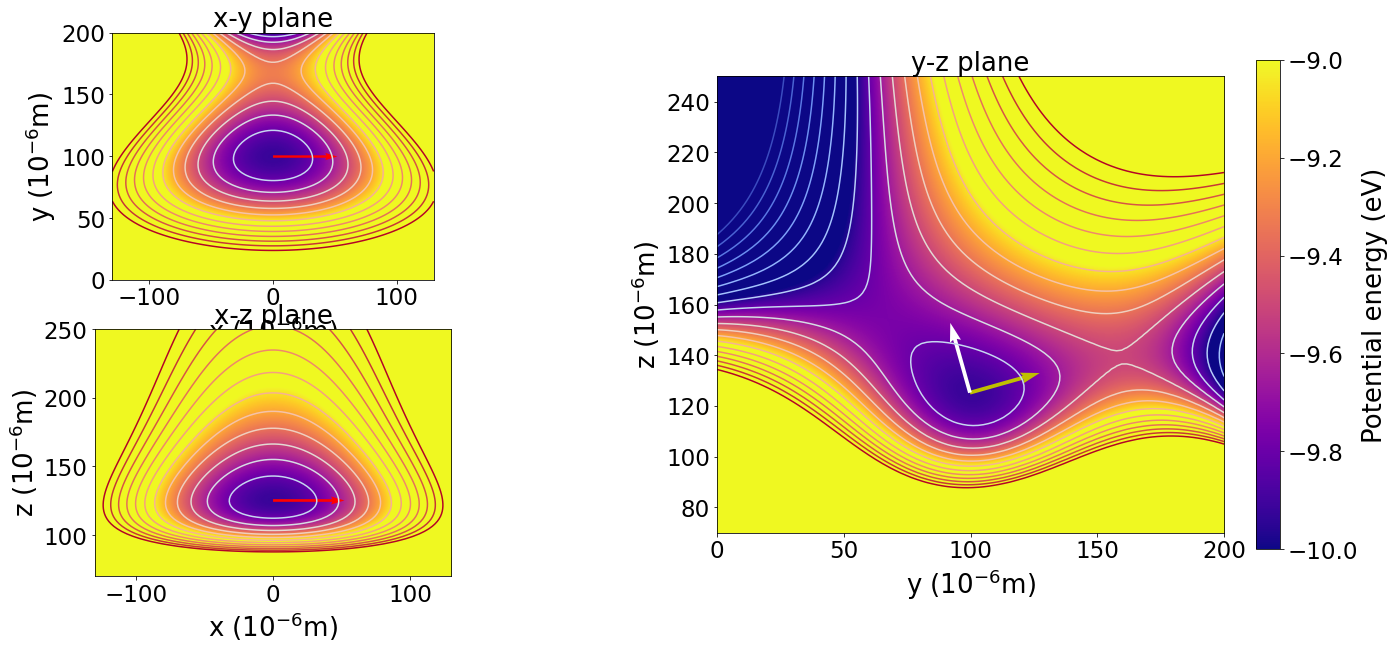

In [36]:
 # #Plot the pseudopotential
with s.with_voltages(dcs = u_set, rfs = None):
    # in with_voltages, all electrodes have to be listed in an array
    # (the array for dcs also contains the RF electrode)
    
    # 2D plot settings
    
    n=100 # resolution of meshgrid = resolution of 2D plots
    xmin, xmax = -130, 130 #set the plot ranges
    ymin, ymax = 0, 200
    zmin, zmax = 70, 250
    x_cut, y_cut, z_cut = x0[0], x0[1], x0[2]# position of the yz-, xz-, xy- crossection
    v = np.arange(-11, -8, 0.15)# set the range for contour lines (range in eV)
    v_min, v_max = -10., -9 # set the range for colour map (range in eV)
    fs = 26 #set the fontsize
    ls = 23 #set the labelsize
    fig = plt.figure()
    fig.set_size_inches(25,10)
    
    # x-y cross section
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax1.set_title("x-y plane" ,fontsize=fs)
    ax1.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
    ax1.set_ylabel('y ($10^{-6}$m)',fontsize=fs)
    ax1.tick_params(axis='x', labelsize=ls)
    ax1.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[xmin:xmax:1j*n, ymin:ymax:1j*n, z_cut:z_cut+1]
    pot = shaped(s.potential)(xyz)
    x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
    CS=ax1.contour(x, y, p, v, cmap=plt.cm.coolwarm)
    im = ax1.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,ymin,ymax))
    im.set_interpolation('bilinear')
    
    # x-z cross section
    ax2 = plt.subplot2grid((2,2), (1,0))
    ax2.set_title("x-z plane" ,fontsize=fs)
    ax2.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
    ax2.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
    ax2.tick_params(axis='x', labelsize=ls)
    ax2.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[xmin:xmax:1j*n, y_cut:y_cut+1, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))
    CS=ax2.contour(x, z, p, v, cmap=plt.cm.coolwarm)
    im = ax2.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,zmin,zmax))
    im.set_interpolation('bilinear')
    
    # y-z cross section
    ax3 = plt.subplot2grid((2,2), (0,1), rowspan=2)
    ax3.set_title("y-z plane" ,fontsize=fs)
    ax3.set_xlabel('y ($10^{-6}$m)',fontsize=fs)
    ax3.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
    ax3.tick_params(axis='x', labelsize=ls)
    ax3.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[x_cut:x_cut+1, ymin:ymax:1j*n, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n, n) for _ in (xyz[1], xyz[2], pot))
    CS=ax3.contour(x, z, p, v, cmap=plt.cm.coolwarm)
    im = ax3.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(ymin,ymax,zmin,zmax))
    im.set_interpolation('bilinear') 
    
    # add colorbar
    cb = fig.colorbar(im, ax=ax3, shrink=0.9)
    cb.ax.tick_params(labelsize=ls)
    cb.set_label('Potential energy (eV)', fontsize = fs)
    
    #add secular frequencies
    #change color and scale (the fewer, the longer the arrow)
    ax1.quiver(*[[x0[0]],[x0[1]]], mod_dir[0][0], mod_dir[0][1], color=['r'], scale = 5)
    ax2.quiver(*[[x0[0]],[x0[2]]], mod_dir[0][0], mod_dir[0][2], color=['r'], scale = 5)
    ax3.quiver(*[[x0[1]],[x0[2]]], mod_dir[1][1], mod_dir[1][2], color=['y'], scale = 7)
    ax3.quiver(*[[x0[1]],[x0[2]]], mod_dir[2][1], mod_dir[2][2], color=['w'], scale = 7)

In [37]:
minimums = [x1]
axis = 0 # this is axial axis in this example 

with s.with_voltages(dcs = u_set, rfs = None):
    scales = sn.anharmonics(s, minimums, axis, L)
    
scales = scales[0]
print('l2 =', scales[0], '\nl3 =', scales[1], '\nl4 =', scales[2])

l2 = 1.8264500098107872e-06 
l3 = -104.33922608975692 
l4 = -0.0003714995540662583


In [42]:
ion_number = 2

#insert your path to this file here
name = Path('anharmonic_modes.ipynb').stem

s = pl.Simulation(name)

#ions' declaration
ions = {'mass': 40, 'charge': 1}

#placing ion in random cloud near minimum
positions = sn.ioncloud_min(x1*L, ion_number, 10e-6)
s.append(pl.placeions(ions, positions))

#declaration of a five wire trap
s.append(sn.polygon_trap([Omega,Omega], [Vrf,Vrf], dc_set, RF_electrodes, DC_electrodes))

#cooling simulation
s.append(pl.langevinbath(0, 1e-7))

#files with simulation information
s.append(pl.dump('anharmonic_positions.txt', variables=['x', 'y', 'z'], steps=10))
s.append(pl.evolve(1e5))
s.execute()

Reducing timestep to 3.978873577297384e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  2 settings made for charge
2 atoms in group 1
2 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 3.97887e-10
Per MPI rank memory allocation (min/avg/max) = 4.78 | 4.78 | 4.78 Mbytes
Step CPU 
       0            0 
   100

In [43]:
_, data = pl.readdump('anharmonic_positions.txt')

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

ion_positions = np.zeros([ion_number, 3])
sort = np.argsort(final_x)

k=0
for i in sort:
    ion_positions[k] = np.array([final_x[i], final_y[i], final_z[i]])
    k+=1

print('Final positions of ions:\n', ion_positions)

Final positions of ions:
 [[-5.74306e-06 -4.72310e-03 -3.73133e-03]
 [-3.38267e-06 -3.51863e-03 -4.92012e-03]]
